In [15]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import os
from os import listdir
import shutil
from shapely.geometry import Polygon

In [2]:
def discrete_cmap(N, base_cmap = None):
    #Create an N-bin discrete colormap from the specified input map
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def voronoi_finite_polygons_2d(vor, radius = None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

Load dataframe with wells and corresponding clusters

In [8]:
# в этом блоке нужно задавать имя файла с именами скважин и соответсвующим им кластерам
path = 'Clusters/'
wells_and_clusters = pd.read_pickle(path + 'poro.pkl') # Qoil.pkl, poro.pkl
wells_and_clusters['Well'] = wells_and_clusters.Well.astype(str)
wells_and_clusters.head(20)

,Well,Cluster
0,F,0
1,C,0
2,A,1
3,B,1
4,E,1
5,D,2


Load dataframe with well and corresponding coordinates

In [9]:
# в этом блоке нужно менять название файла с координатами скважин
path = 'RAW DATA/Well Data_LAS/'
# 'Coordinates.xlsx' координаты скважин для каротажей
# 'Coordinates_hist.xlsx' координаты скважин для продакшн профайлов
data = pd.read_excel(path + 'Coordinates.xlsx') 
#data.Well = data.Well.astype(str)
data

,X,Y,Well
0,1332664.00,283884.00,A
1,1344800.00,287656.00,B
2,1315608.00,285360.00,C
3,1311508.00,280276.00,D
4,1333457.76,288754.80,E
5,1304242.80,283920.08,F


Merge two dataframes on 'Well' column

In [10]:
data = data.merge(wells_and_clusters, on = 'Well', how = 'left')
data

,X,Y,Well,Cluster
0,1332664.00,283884.00,A,1
1,1344800.00,287656.00,B,1
2,1315608.00,285360.00,C,0
3,1311508.00,280276.00,D,2
4,1333457.76,288754.80,E,1
5,1304242.80,283920.08,F,0


3


/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


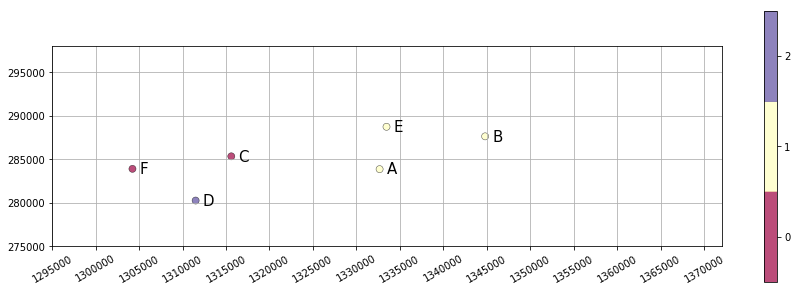

In [22]:
number_of_clusters = len(data.Cluster.unique())
print(number_of_clusters)
plt.figure(figsize=(15, 5))
plt.scatter(data.X, data.Y, cmap = discrete_cmap(number_of_clusters, 'Spectral'), 
            c = data.Cluster, marker = 'o', lw = .5, edgecolors = 'black', s = 50, alpha = .7)
plt.colorbar(ticks = range(number_of_clusters))
plt.clim(-0.5, number_of_clusters - 0.5)

for label, x, y in zip(data.Well, data.X, data.Y):
    plt.annotate(label, xytext = (7, -5), textcoords = 'offset points', xy = (x, y), size = 15)  

plt.xlim(1295000, 1372000) 
plt.ylim(275000, 298000)
plt.axes().set_aspect(1)
plt.yticks(np.arange(275000, 298000, 5000))
plt.xticks(np.arange(1295000, 1372000, 5000));
plt.grid()
plt.xticks(rotation = 30);

/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


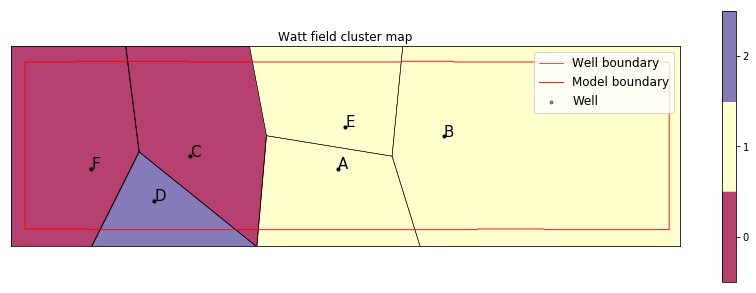

In [26]:
plt.figure(figsize=(15, 5))

coordinates = np.array(data[['X', 'Y']])
points = coordinates
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

speed = np.array(data['Cluster'])
# find min/max values for normalization
minima = min(speed)
maxima = max(speed)

# normalize chosen colormap
norm = mpl.colors.Normalize(vmin = minima, vmax = maxima, clip=True)
mapper = cm.ScalarMappable(norm = norm, cmap = cm.Spectral)

# plot borders and fill of Voronoi cells
count = 0
for i in regions:
    points = vertices[i]
    x = points[:, 0]
    y = points[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    plt.plot(x, y, 'k', linewidth = .5)
    plt.fill(*zip(*points), alpha = .75, color = mapper.to_rgba(speed[count]))
    count +=1
plt.plot(x, y, 'k', linewidth = .5, label = 'Well boundary')

# plot well locations
coordinates = np.array(data[['X', 'Y']]) 
points = coordinates    
plt.plot(points[:,0], points[:,1], 'ko',  markersize = 3)

plt.xlim(1295000, 1372000) 
plt.ylim(275000, 298000)
plt.axes().set_aspect(1)

path = 'Polygons_Watt/Watt_model_boundary'
file = open(path, 'r')
x_polygon = []
y_polygon = []
for line in file:
    x_temp = float(line.split(' ', 1)[0])
    y_temp = float(line.split(' ', 1)[1].split(' ', 1)[0])
    x_polygon.append(x_temp)
    y_polygon.append(y_temp)
file.close()
x_polygon = x_polygon[:-1]
y_polygon = y_polygon[:-1]
polygon = np.column_stack((x_polygon, y_polygon))
plt.plot(x_polygon, y_polygon, 'red', linewidth = .9, label = 'Model boundary')

plt.scatter(data.X, data.Y, cmap = discrete_cmap(number_of_clusters, 'Spectral'), 
    c = data.Cluster, marker='o', lw = .5, edgecolors = 'black', s = 10, alpha = 0.75, label = 'Well')

for label, x, y in zip(data.Well, data.X, data.Y):
    plt.annotate(label, xy = (x, y), size = 15)


legend = plt.legend(loc = 'upper right', shadow = False, 
                    fontsize = 'large')
legend.get_frame()

plt.axes().set_aspect(1)
plt.yticks(np.arange(275000, 298000, 5000))
plt.xticks(np.arange(1295000, 1372000, 5000));
plt.colorbar(ticks = range(number_of_clusters))
plt.clim(-0.5, number_of_clusters - 0.5)
plt.title('Watt field cluster map')
plt.xticks([])
plt.yticks([])
plt.show()

Write polygon coordinates into files

/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


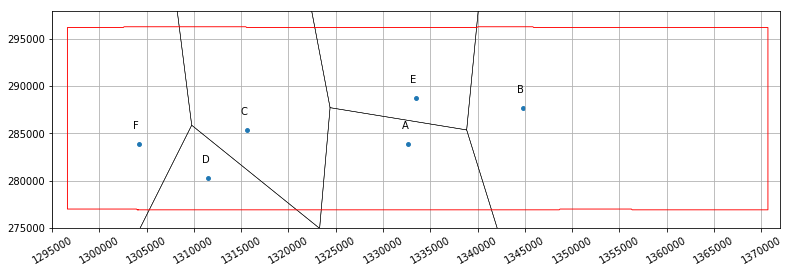

In [13]:
path = r'Polygons_Watt/poro/' 
if not os.path.exists(path):
    os.makedirs(path)
    
path = 'Polygons_Watt/Polygons/'
coordinates = np.array(data[['Well', 'X', 'Y']])
points = coordinates  
wells = data.Well.unique()

plt.figure(figsize=(15, 4))
count = 0
for i in regions:
    points = vertices[i]
    x = points[:, 0]
    y = points[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    path = 'Polygons_Watt/poro/'
    path = path + wells[count]
    f = open(path, 'w+')
    for i in range(len(x)):
        temp = str(x[i]) + ' ' + str(y[i]) + ' ' + '0.000000\n'
        f.write(str(temp))
    f.write('999.0 999.0 999.0')
    f.close()
    plt.plot(x, y, 'k', linewidth = .5)
    count += 1
plt.scatter(data.X, data.Y, marker = 'o', s = 15, alpha=1)
for label, x, y in zip(data.Well, data.X, data.Y):
    plt.annotate(label, xytext = (-6, 15), textcoords = 'offset points', xy = (x, y), size = 10)    

# code for plottong model boundary
path = 'Polygons_Watt/Watt_model_boundary'
file = open(path, 'r')
x_polygon = []
y_polygon = []
for line in file:
    x_temp = float(line.split(' ', 1)[0])
    y_temp = float(line.split(' ', 1)[1].split(' ', 1)[0])
    x_polygon.append(x_temp)
    y_polygon.append(y_temp)
file.close()
x_polygon = x_polygon[:-1]
y_polygon = y_polygon[:-1]
polygon = np.column_stack((x_polygon, y_polygon))
plt.plot(x_polygon, y_polygon, 'red', linewidth = 0.9)    

plt.xlim(1295000, 1372000) 
plt.ylim(275000, 298000)
plt.axes().set_aspect(1)
plt.yticks(np.arange(275000, 298000, 5000))
plt.xticks(np.arange(1295000, 1372000, 5000))
plt.grid();
plt.xticks(rotation = 30)
plt.show()

In [16]:
path = 'Polygons_Watt/poro/'
list_of_wells = listdir(path)
files_to_remove = ['0_polygon', '1_polygon', '2_polygon', '.ipynb_checkpoints']
list_of_wells = [i for i in list_of_wells if i not in files_to_remove]
list_of_wells.sort()
print(len(list_of_wells))
print(list_of_wells)
# output должен быть вида:
# ['A', 'B', 'C', 'D', 'E', 'F'] (6) или
# ['1', '10', '1A', '1B', '2', '2A', '3', '3A', '4', '4A', '5', '5A', '6', '7', '8', '9'] (16)
# если есть другие фалы то нужно их добавить из в 'files_to_remove'

6
['A', 'B', 'C', 'D', 'E', 'F']


Cut polygons by model boundary

In [18]:
# код создает файлы с координатами ячеек Вороного для каждой скважины, теперь можно грузить их 
# в Petrel как полигоны
for j in list_of_wells:
    path = 'Polygons_Watt/poro/'
    path = path + str(j)
    file = open(path, 'r')
    x_polygon = []
    y_polygon = []
    for line in file:
        x_temp = float(line.split(' ', 1)[0])
        y_temp = float(line.split(' ', 1)[1].split(' ', 1)[0])
        x_polygon.append(x_temp)
        y_polygon.append(y_temp)
    file.close()
    x_polygon = x_polygon[:-1]
    y_polygon = y_polygon[:-1]
    polygon = np.column_stack((x_polygon, y_polygon))
    polygon_coordinates = tuple()
    for i in range(len(x_polygon)):
        temp =  (x_polygon[i], y_polygon[i])
        polygon_coordinates = polygon_coordinates + (temp,)
    well_area = Polygon(polygon_coordinates)
    path = 'Polygons_Watt/Watt_model_boundary'
    file = open(path, 'r')
    x_polygon = []
    y_polygon = []
    for line in file:
        x_temp = float(line.split(' ', 1)[0])
        y_temp = float(line.split(' ', 1)[1].split(' ', 1)[0])
        x_polygon.append(x_temp)
        y_polygon.append(y_temp)
    file.close()
    x_polygon = x_polygon[:-1]
    y_polygon = y_polygon[:-1]
    polygon = np.column_stack((x_polygon, y_polygon))
    polygon_coordinates = tuple()
    for i in range(len(x_polygon)):
        temp =  (x_polygon[i], y_polygon[i])
        polygon_coordinates = polygon_coordinates + (temp,)
    model_area = Polygon(polygon_coordinates)
    polygon = well_area.intersection(model_area)
    polygon_coordinates = list(polygon.exterior.coords)
    path = 'Polygons_Watt/poro/'
    path = path + str(j)
    f = open(path, 'w+')
    for i in range(len(polygon_coordinates)):
        temp = str(polygon_coordinates[i][0]) + ' ' + str(polygon_coordinates[i][1]) + ' ' + '0.000000\n'
        f.write(str(temp))
    f.write('999.0 999.0 999.0')
    f.close()

In [19]:
wells = list(data.Well.values)
clusters = list(data.Cluster.values)
clusters = np.array(clusters)
well_names = []
for j in np.unique(clusters):
    sublist = []
    for i in range(len(clusters)):
        if clusters[i] == j:
            temp = wells[i]
            sublist.append(temp)
    well_names.append(sublist)
print(well_names)
print(len(np.unique(clusters)), 'clusters in data')

[['C', 'F'], ['A', 'B', 'E'], ['D']]
3 clusters in data


Combine Voronoi diagrams into spatial clusters

In [20]:
for k in range(len(well_names)): # times equal to number of cluster plus one
    print(well_names[k])
    count = 0
    for j in range(len(well_names[k])):
        print(well_names[k][j])
        if count == 0:
            path = 'Polygons_Watt/poro/'
            path = path + str(well_names[k][j])
            file = open(path, 'r')
            x_polygon = []
            y_polygon = []
            for line in file:
                x_temp = float(line.split(' ', 1)[0])
                y_temp = float(line.split(' ', 1)[1].split(' ', 1)[0])
                x_polygon.append(x_temp)
                y_polygon.append(y_temp)
            file.close()
            x_polygon = x_polygon[:-1]
            y_polygon = y_polygon[:-1]
            polygon = np.column_stack((x_polygon, y_polygon))
            polygon_coordinates = tuple()
            for i in range(len(x_polygon)):
                temp =  (x_polygon[i], y_polygon[i])
                polygon_coordinates = polygon_coordinates + (temp,)
            well_area = Polygon(polygon_coordinates)
            path = 'Polygons_Watt/poro/'
            if len(well_names[k]) != 1:   
                path = path + str(well_names[k][j + 1])
                file = open(path, 'r')
                x_polygon = []
                y_polygon = []
                for line in file:
                    x_temp = float(line.split(' ', 1)[0])
                    y_temp = float(line.split(' ', 1)[1].split(' ', 1)[0])
                    x_polygon.append(x_temp)
                    y_polygon.append(y_temp)
                file.close()
                x_polygon = x_polygon[:-1]
                y_polygon = y_polygon[:-1]
                polygon = np.column_stack((x_polygon, y_polygon))
                polygon_coordinates = tuple()
                for i in range(len(x_polygon)):
                    temp =  (x_polygon[i], y_polygon[i])
                    polygon_coordinates = polygon_coordinates + (temp,)
                model_area = Polygon(polygon_coordinates)
                polygon_final = well_area.union(model_area)
            else:
                path = path + str(well_names[k][j])
                file = open(path, 'r')
                x_polygon = []
                y_polygon = []
                for line in file:
                    x_temp = float(line.split(' ', 1)[0])
                    y_temp = float(line.split(' ', 1)[1].split(' ', 1)[0])
                    x_polygon.append(x_temp)
                    y_polygon.append(y_temp)
                file.close()
                x_polygon = x_polygon[:-1]
                y_polygon = y_polygon[:-1]
                polygon = np.column_stack((x_polygon, y_polygon))
                polygon_coordinates = tuple()
                for i in range(len(x_polygon)):
                    temp =  (x_polygon[i], y_polygon[i])
                    polygon_coordinates = polygon_coordinates + (temp,)
                model_area = Polygon(polygon_coordinates)
                polygon_final = well_area.union(model_area)
        else:
            path = 'Polygons_Watt/poro/'
            path = path + str(well_names[k][j])
            file = open(path, 'r')
            x_polygon = []
            y_polygon = []
            for line in file:
                x_temp = float(line.split(' ', 1)[0])
                y_temp = float(line.split(' ', 1)[1].split(' ', 1)[0])
                x_polygon.append(x_temp)
                y_polygon.append(y_temp)
            file.close()
            x_polygon = x_polygon[:-1]
            y_polygon = y_polygon[:-1]
            polygon = np.column_stack((x_polygon, y_polygon))
            polygon_coordinates = tuple()
            for i in range(len(x_polygon)):
                temp =  (x_polygon[i], y_polygon[i])
                polygon_coordinates = polygon_coordinates + (temp,)
            well_area = Polygon(polygon_coordinates)
            polygon_final = polygon_final.union(well_area)
        count += 1    
    
    if polygon_final.type == 'Polygon':
        polygon_coordinates = list(polygon_final.exterior.coords)
        path = 'Polygons_Watt/poro/'
        path = path + str(k) + '_polygon'
        f = open(path, 'w+')
        for i in range(len(polygon_coordinates)):
            temp = str(polygon_coordinates[i][0]) + ' ' + str(polygon_coordinates[i][1]) + ' ' + '0.000000\n'
            f.write(str(temp))
        f.write('999.0 999.0 999.0')
        f.close()
    elif polygon_final.type == 'MultiPolygon':
        print('Oops, I did it again!')
        sub_polygon = 0
        for p in polygon_final:
            print(sub_polygon)
            polygon_coordinates = list(p.exterior.coords)
            path = 'Polygons_Watt/poro/'
            path = path + str(k) + '_polygon_' + str(sub_polygon)
            f = open(path, 'w+')
            for i in range(len(polygon_coordinates)):
                temp = str(polygon_coordinates[i][0]) + ' ' + str(polygon_coordinates[i][1]) + ' ' + '0.000000\n'
                f.write(str(temp))
            f.write('999.0 999.0 999.0')
            f.close()
            sub_polygon += 1
    print('---')

['C', 'F']
C
F
---
['A', 'B', 'E']
A
B
E
---
['D']
D
---


/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


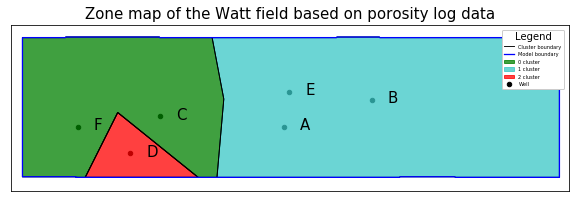

In [21]:
# в строке 13 нужно указать какие полигоны нужно рисовать
# они будут в папке с полигонами скважин
# чтобы закрашивать полигоны одного кластера в один цвет нужно в нужном порядке расставить цвета в
# 'customPalette' и поменять значение в строке 33 или предпочтительнее иначе задать порядок
# полигонов к отрисовке или вообще избавиться от if в 34-37 строках
fontsize = 10
customPalette = ['green',  '#39C8C6', 'red', 'red', '#630C3A', 'Orange', '#3498DB', 'Tomato', 'Violet', "#9B59B6", 
                 "#3498DB", "Coral", "#E74C3C", "Brown", "Goldenrod", '#630C3A', '#39C8C6', 
                 'Orange', '#3498DB', 'Tomato', 'Violet', "#9B59B6", "#3498DB", "Coral", 
                 "#E74C3C", "Brown", "Goldenrod"]

#list_of_files = ['0_polygon', '1_polygon','2_polygon_0','2_polygon_1']
list_of_files = ['0_polygon', '1_polygon','2_polygon']

plt.figure(figsize = (10, 4))

j = 0
for i in list_of_files:
    path = 'Polygons_Watt/poro/'
    path = path + i
    file = open(path, 'r')
    x_polygon = []
    y_polygon = []
    for line in file:
        x_temp = float(line.split(' ', 1)[0])
        y_temp = float(line.split(' ', 1)[1].split(' ', 1)[0])
        x_polygon.append(x_temp)
        y_polygon.append(y_temp)
    file.close()
    x_polygon = x_polygon[:-1]
    y_polygon = y_polygon[:-1]
    polygon = np.column_stack((x_polygon, y_polygon))
    plt.plot(x_polygon, y_polygon, 'k', linewidth = .9)
    if j < 3:
        plt.fill(x_polygon, y_polygon, alpha = .75, color = customPalette[j], 
             label = str(j) + ' cluster')
    else: plt.fill(x_polygon, y_polygon, alpha = .75, color = customPalette[j])
    j += 1
plt.plot(x_polygon, y_polygon, 'k', linewidth = .9, label = 'Cluster boundary')

path = 'Polygons_Watt/Watt_model_boundary'
file = open(path, 'r')
x_polygon = []
y_polygon = []
for line in file:
    x_temp = float(line.split(' ', 1)[0])
    y_temp = float(line.split(' ', 1)[1].split(' ', 1)[0])
    x_polygon.append(x_temp)
    y_polygon.append(y_temp)
file.close()
x_polygon = x_polygon[:-1]
y_polygon = y_polygon[:-1]
polygon = np.column_stack((x_polygon, y_polygon))
plt.plot(x_polygon, y_polygon, 'blue', linewidth = 1.3, label = 'Model boundary')
    
plt.scatter(data.X, data.Y, marker = 'o',  c = 'k', s = 20, label = 'Well')


legend = plt.legend(loc = 'upper right', ncol = 1, borderaxespad = 1, shadow = False,
    fontsize = fontsize - 5, frameon = True, fancybox = True, framealpha = 1, title = 'Legend')
legend.get_frame()

plt.clim(-0.5, number_of_clusters - 0.5)
plt.title('Zone map of the Watt field based on porosity log data', fontsize = 15)
plt.xlim(1295000, 1372000) 
plt.ylim(275000, 298000)
plt.xticks([])
plt.yticks([])
plt.axes().set_aspect(1)
plt.grid()
plt.xticks(rotation = 30)

# если визуализируется продакшн дата то можно использовать код в комментах далее для более красивой
# визуализации имен скважин закомментив предворительно следующие 2 строки кода
for label, x, y in zip(data.Well, data.X, data.Y):
        plt.annotate(label, xytext = (16, -3), textcoords = 'offset points', xy = (x, y), size = 15)
"""
fontsize = 17
plt.text(1301800, 283000, '7', fontsize = fontsize)
plt.text(1308000, 279500, '10', fontsize = fontsize)
plt.text(1306000, 285600, '5', fontsize = fontsize)
plt.text(1306000, 283000, '5A', fontsize = fontsize)
plt.text(1317000, 284700, '8', fontsize = fontsize)
plt.text(1313000, 282200, '2', fontsize = fontsize)
plt.text(1313000, 280500, '2A', fontsize = fontsize)
plt.text(1324000, 285000, '1A', fontsize = fontsize)
plt.text(1320000, 286000, '1', fontsize = fontsize)
plt.text(1319000, 283500, '1B', fontsize = fontsize)
plt.text(1322900, 282700, '3', fontsize = fontsize)
plt.text(1322900, 280700, '3A', fontsize = fontsize)
plt.text(1335000, 288600, '9', fontsize = fontsize)
plt.text(1330000, 285600, '4', fontsize = fontsize)
plt.text(1329000, 283600, '4A', fontsize = fontsize)
plt.text(1335000, 282000, '6', fontsize = fontsize)
"""
plt.show()

In [138]:
# удалить папку и ее содержимое
# удобно если в следующий раз будут визуализироваться другие данные
path = 'Polygons_Watt/poro/'
shutil.rmtree(path)